In [411]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import PIL
import os
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization

# Local imports
import sys
sys.path.append('../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts

In [412]:
%matplotlib notebook

In [413]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [414]:
# Set defaults for the analysis
numforhist = 20
accumlist = [] # This will be all segments unless overridden 
rminforhist = 1e-7
rmaxforhist = .6

# Only turn this on if we want PDF in terms of Z^2
IwantZ2intervals = True
numforZ2hist = 10
Z2minforhist = 1e-5
Z2maxforhist = .0002

In [415]:
# Specify the file we want to analyze (and output file name)
Segmentroot='benchmark'

In [416]:
# Derivative names
Compressedfilename = Segmentroot+'retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentroot+'roughness.jpg'; print(Roughnessfile)
RoughnessZ2file = Segmentroot+'roughnessZ2.jpg'; print(RoughnessZ2file)
Roughnessdatafile=Segmentroot+'roughness.txt'; print(Roughnessdatafile)
Roughnessfitfile=Segmentroot+'roughnessfit.txt'; print(Roughnessfitfile)

benchmarkretrieved.npz
benchmarkroughness.jpg
benchmarkroughnessZ2.jpg
benchmarkroughness.txt
benchmarkroughnessfit.txt


In [417]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
dx = dy = 0.5

In [418]:
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
solution = npzfile['solution']
nsegments = len(nx1list)
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]

In [419]:
# Setting up null arrays
hbins_accum = []
meanrsub_accum = []
zsigma_accum = []
Z2_accum = []
Zsquared_accum = []
rsub_accum = []
meanrsublist = []
Zsigmalist = []
Z2list = []

# And a graphics parameter
stride = 1

In [420]:
# Now, to evaluate the roughness ... First step is to flatten each panel via rotation
# Here we explicitly flip the y-coordinate (to make it a right-handed system) so we don't have to invert on the fly

for isegment in range(0,nsegments):

    # Extract this segment
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nxsegment = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; nysegment = ny2-ny1+1
    surf_xseg = np.linspace(0,(nxsegment-1)*dx,nxsegment); 
    surf_yseg = np.linspace(0,(nysegment-1)*dy,nysegment); 
    surf_xseggrid, surf_yseggrid = np.meshgrid(surf_xseg,surf_yseg) # 1st index is y, 2nd is x
    surf_zseggrid = copy.copy(np.flipud(solution[ny1:ny2+1,nx1:nx2+1])) # This flips the y-coordinate

    # Fit a plane to the data and adjust data to start at the origin
    m = ims.polyfit2d(\
                  surf_xseggrid.reshape(nysegment*nxsegment), \
                  surf_yseggrid.reshape(nysegment*nxsegment), \
                  surf_zseggrid.reshape(nysegment*nxsegment), \
                  linear=True,order=1)

    # Get the angles of the plane
    dzdy = m[1]; thetay = np.arctan(dzdy)*180/np.pi; #print 'y:', thetay

    # Get rotation matrix & flatten in one direction
    Roty = ims.myrotation_matrix([1,0,0], -thetay)
    surf_xseggridp, surf_yseggridp, surf_zseggridp = \
        ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Roty)

    # Fit a plane to the data and adjust data to start at the origin
    mp = ims.polyfit2d(\
                  surf_xseggridp.reshape(nysegment*nxsegment), \
                  surf_yseggridp.reshape(nysegment*nxsegment), \
                  surf_zseggridp.reshape(nysegment*nxsegment), \
                  linear=True,order=1)

    # Get the angle of the plane in another direction
    dzdx = mp[2]; thetaxp = np.arctan(dzdx)*180/np.pi; #print 'x:', thetaxp

    # Get rotation matrix & flatten in another direction
    Rotxp = ims.myrotation_matrix([0,1,0], thetaxp)
    surf_xseggridpp, surf_yseggridpp, surf_zseggridpp = \
        ims.flatten(surf_xseggridp, surf_yseggridp, surf_zseggridp, Rotxp)


    # Trying out the polyval2d
    surf_zseggrid_theory_long = ims.polyval2d(\
                  surf_xseggrid.reshape(nysegment*nxsegment), \
                  surf_yseggrid.reshape(nysegment*nxsegment), \
                  m)
    surf_zseggrid_theory = surf_zseggrid_theory_long.reshape(nysegment,nxsegment)
    #surf_zseggrid_theory -= z0
    surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory = \
        ims.flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid_theory, Roty)
    surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory = \
        ims.flatten(surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory, Rotxp)

    # Now rotate
    deltay = surf_yseggridpp_theory[0,-1]-surf_yseggridpp_theory[0,0]
    deltax = surf_xseggridpp_theory[0,-1]-surf_xseggridpp_theory[0,0]
    thetazpp = -np.arctan(deltay/deltax)*180/np.pi;
    Rotzpp = ims.myrotation_matrix([0,0,1], thetazpp)
    surf_xseggridppp, surf_yseggridppp, surf_zseggridppp = \
        ims.flatten(surf_xseggridpp, surf_yseggridpp, surf_zseggridpp, Rotzpp)
    surf_xseggridppp_theory, surf_yseggridppp_theory, surf_zseggridppp_theory = \
        ims.flatten(surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory, Rotzpp)

    # Now we have to extract an orthogonal subset
    dxsub = dysub = dx
    xsubstart = np.max(surf_xseggridppp_theory[[0,-1],0])+dxsub*2
    xsubstop = np.min(surf_xseggridppp_theory[[0,-1],-1])-dxsub*2
    ysubstart = np.max(surf_yseggridppp_theory[0,[0,-1]])+dysub*2
    ysubstop = np.min(surf_yseggridppp_theory[-1,[0,-1]])-dysub*2
    xsub = np.arange(xsubstart,xsubstop,dxsub)
    ysub = np.arange(ysubstart,ysubstop,dysub)
    sub_xseggrid, sub_yseggrid = np.meshgrid(xsub,ysub) # 1st index is y, 2nd is x
    nsuby, nsubx = np.shape(sub_xseggrid)
    surf_xseggridppp_theory_long = np.reshape(surf_xseggridppp_theory,nysegment*nxsegment)
    surf_yseggridppp_theory_long = np.reshape(surf_yseggridppp_theory,nysegment*nxsegment)
    points = np.vstack((surf_xseggridppp_theory_long,surf_yseggridppp_theory_long)).T # rows are x,y pairs
    values = np.reshape(surf_zseggridppp,nysegment*nxsegment)
    sub_zseggrid_long = griddata(points, values, (sub_xseggrid, sub_yseggrid), method='cubic')
    sub_zseggrid = np.reshape(sub_zseggrid_long,(nsuby, nsubx))

    # Now we get the roughness
    dzsub_dx = np.diff(sub_zseggrid,axis=1)/np.diff(sub_xseggrid,axis=1)
    dzsub_dy = np.diff(sub_zseggrid,axis=0)/np.diff(sub_yseggrid,axis=0)
    Zsquared = dzsub_dx[1:,:]**2+dzsub_dy[:,1:]**2
    rsub = 1.0 - 1/np.sqrt(1+Zsquared)
    mu = 1-rsub
    phi = np.arccos(mu)
    Zplus = Zsquared**.5
    Z = np.hstack((Zplus,-Zplus)) # Need +/- to generate a two-sided distribution
    thismeanrsub = np.round(np.mean(rsub)*1000)/1000; meanrsublist.append(thismeanrsub)
    thissigma = np.round(np.std(Z)*100)/100; Zsigmalist.append(thissigma)
    thismeanZ2 = np.mean(Zsquared); Z2list.append(thismeanZ2)

    # Plotting surfaces
    title1 = 'panel_' +list(map(str,[isegment+1]))[0]#"TypeError: 'map' object is not subscriptable" stackoverflow said added the list() so the map is indexable

    # Numerical distribution functions
    rsub_long = np.reshape(rsub,np.size(rsub))

    # This needs to be changed to adjust for log spacing
    if(IwantZ2intervals==True):
        Z2bins = np.linspace(Z2minforhist,Z2maxforhist,numforZ2hist)
        newrbins = 1-(1/(Z2bins+1))**.5
    else:
        newrbins=np.geomspace(rminforhist,rmaxforhist,num=numforhist)
    hist = np.histogram(rsub_long,bins=newrbins)

    rbins = hist[1][0:-1]
    rbins1 = hist[1][1:]
    hbins = hist[0] 
    norm = -np.trapz(rbins,hbins)
    hbins = hbins/norm

    # Defining the analytical distribution function bins
    rwidth = rbins1-rbins
    rbinsW = (rbins+rwidth/2.0)        

    # Accumulate the binned data
    if isegment in accumlist:
        hbins_accum.append(hbins)
        meanrsub_accum.append(thismeanrsub)
        zsigma_accum.append(thissigma)
        Z2_accum.append(thismeanZ2)

        Zsquared_long = np.reshape(Zsquared,np.size(Zsquared))
        Zsquared_accum = np.append(Zsquared_accum,Zsquared_long)

        rsub_long = np.reshape(rsub,np.size(rsub))
        rsub_accum = np.append(rsub_accum,rsub_long)

        print('Accumulating ...', np.shape(Zsquared), np.shape(Zsquared_long), np.shape(Zsquared_accum))


print(newrbins)
for isegment in range(len(meanrsublist)):
    print('segment, #pts, <r>, sigma =', \
         isegment, np.size(rsub), meanrsublist[isegment], Zsigmalist[isegment])

../imagestuff.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)


Accumulating ... (45, 44) (1980,) (1980,)
[4.99996250e-06 1.55551926e-05 2.61100885e-05 3.66646501e-05
 4.72188776e-05 5.77727709e-05 6.83263300e-05 7.88795549e-05
 8.94324458e-05 9.99850025e-05]
segment, #pts, <r>, sigma = 0 1980 0.0 0.01


In [421]:
# This calculates a normalized observed PDF as a function of ln(r)
hbins_total = np.sum((hbins_accum),axis=0)/len(accumlist)
norm = -np.trapz(np.log(rbinsW),hbins_total); print(norm)
hbins_total = hbins_total/norm

-525826.4988224165


<IPython.core.display.Javascript object>


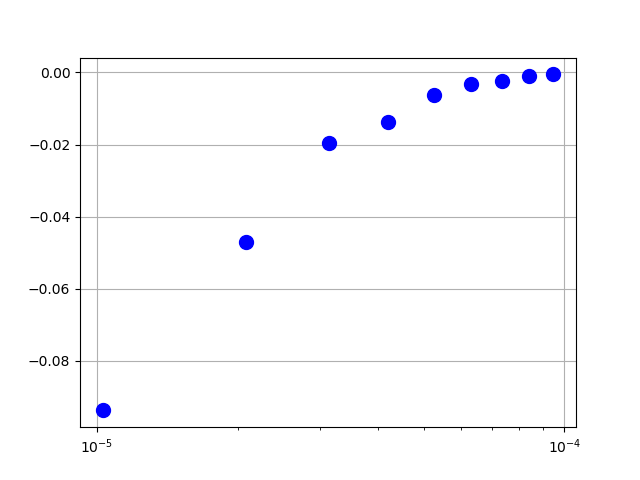

In [422]:
# Graph the ln(r) PDF
plt.figure()
plt.semilogx(rbinsW,hbins_total,'ob',markersize=10, label='obs')
plt.grid(True)

<IPython.core.display.Javascript object>


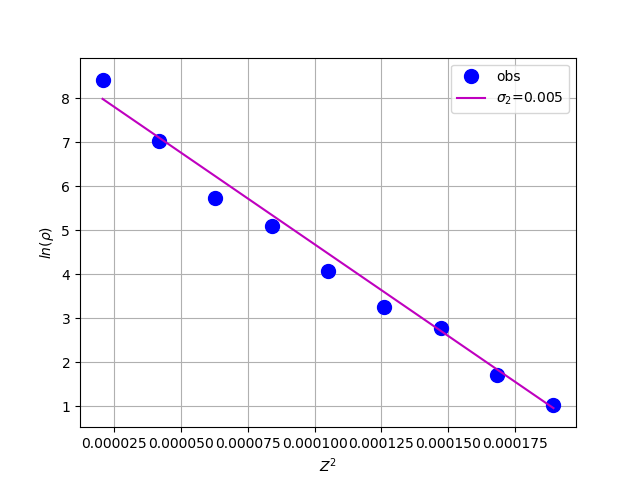

[-4.15956750e+04  8.84289352e+00] predicted sigma2 =  0.004903158264024999


In [427]:
if (IwantZ2intervals):

    # This calculates a normalized observed PDF as a function of Z^2 (rho(Z^2))
    Z2binsW = 1/(1-rbinsW)**2-1
    hbins_total_Z2 = -hbins_total/rbinsW*(1-rbinsW)**3/2
    ikeep = np.nonzero(hbins_total_Z2)
    Z2keep = Z2binsW[ikeep]
    logrhoZ2 = np.log(hbins_total_Z2[ikeep])

    # Graph the Z^2 PDF
    plt.figure()
    plt.plot(Z2keep,logrhoZ2,'ob',markersize=10, label='obs')

#     # Do some polyfitting
#     p1 = np.polyfit(Z2keep[0:3],logrhoZ2[0:3],1)
#     best_sigma1 = 1/np.sqrt(-p1[0])
#     print(p1,'predicted sigma1 = ', best_sigma1)
#     label_sigma1 = '$\sigma_1$='+str(np.round(best_sigma1*100)/100) 
#     plt.plot(Z2keep,np.polyval(p1,Z2keep),'g', label=label_sigma1)

    
    p2 = np.polyfit(Z2keep[-3:],logrhoZ2[-3:],1)
    best_sigma2 = 1/np.sqrt(-p2[0])
    print(p2,'predicted sigma2 = ', best_sigma2)
    label_sigma2 = '$\sigma_2$='+str(np.round(best_sigma2*1000)/1000) 
    plt.plot(Z2keep,np.polyval(p2,Z2keep),'m', label=label_sigma2)


#     p3 = np.polyfit(Z2keep,logrhoZ2,1)
#     best_sigma3 = 1/np.sqrt(-p2[0])
#     print(p3,'predicted sigma3 = ', best_sigma3)
#     label_sigma3 = '$\sigma_3$='+str(np.round(best_sigma3*100)/100) 
#     plt.plot(Z2keep,np.polyval(p3,Z2keep),'m', label=label_sigma3)

    # Annotate
    plt.grid(True)
    plt.ylim([np.min(logrhoZ2)-.5,np.max(logrhoZ2)+.5])
    plt.xlabel('$Z^2$')
    plt.ylabel(r'$ln(\rho)$')
    plt.legend()

    # Save
    plt.savefig(RoughnessZ2file)


<IPython.core.display.Javascript object>


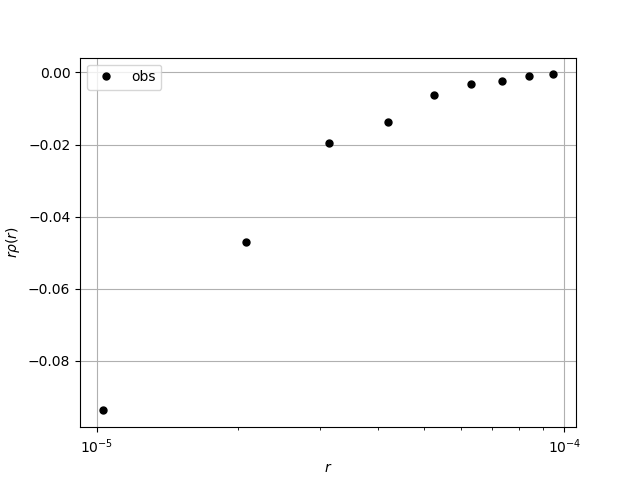

In [424]:
# Graph
plt.figure()
label_obs = 'obs'
plt.semilogx(rbinsW,hbins_total,'ok',markersize=5, label=label_obs)
# plt.semilogx(rbinsW,hbins_gauss,'--g',linewidth=2, label=label_Gauss)
# plt.semilogx(rbinsW,hbins_bestfit,'-b',linewidth=2, label=label_Weibull)
# plt.semilogx(rbinsW,hbins_bimodal,'-.m',linewidth=2, label=label_bimodal)
plt.grid(True)
plt.xlabel(r'$r$',fontsize=fontsize)
plt.ylabel(r'$r\rho(r)$',fontsize=fontsize)
plt.legend(loc='upper left')
#plt.title(case,fontsize=fontsize)

In [425]:
# plt.savefig(Roughnessfile)
# dummy= [rbinsW,hbins_total]
# np.savetxt(Roughnessdatafile,dummy)
# cfile = open(Roughnessfitfile,'w')
# cfile.write('&Roughness_Best_Fit\n')
# cfile.write(case+'\n\n'+'Gaussian fit:'+'\n')
# cfile.write('   '+'sigma =' +str(best_sigmaG)+'\n')
# cfile.write('   '+'R^2 ='+str(R2_G)+'\n\n'+'Weibull fit:'+'\n')
# cfile.write('   '+'sigma =' +str(best_sigmaW)+'\n')
# cfile.write('   '+'eta =' +str(best_eta)+'\n')
# cfile.write('   '+'R^2 ='+str(R2_W)+'\n\n'+'Bimodal fit:'+'\n')
# cfile.write('   '+'sigma1 =' +str(best_sigma1)+'\n')
# cfile.write('   '+'N1 =' +str(best_N1)+'\n')
# cfile.write('   '+'sigma2 =' +str(best_sigma2)+'\n')
# cfile.write('   '+'N2 =' +str(best_N2)+'\n')
# cfile.write('   '+'R^2 ='+str(R2_B)+'\n')
# cfile.close()

In [426]:
# # Just for fun
# r = sts.sigma2meanr(best_sigma1); print(r)
# theta = np.arccos(1-r)*180/np.pi; print(theta)